In [1]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from storage_utils.patients_data_new import patients
import os
from biosppy.signals import ecg
import matplotlylib as pltly


/home/franciscosargo/.virtualenvs/pre-epi-seizures/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def detect_rpeaks(feature_signal, detector, sampling_rate):
    # detect rpeaks
    rpeaks = detector(signal=feature_signal,
                      sampling_rate=sampling_rate)['rpeaks']
    return rpeaks

In [3]:
# Open data file
# load the file

disk='/mnt/Seagate/'
files_dir = 'h5_files_backup/processing_datasets/'
file_name = 'seizure_datasets_new.h5'
file_path = disk + files_dir + file_name
print file_path
f = h5py.File(file_path, 'r')


/mnt/Seagate/h5_files_backup/processing_datasets/seizure_datasets_new.h5


In [4]:
# Get Filtered and Detrended signal

# patient parameters
patient_number=3
patient_info = patients[str(patient_number)]
patient_info

# feature for analysis
feature_name=('signals/3000_1200'
              '/raw'
              '/baseline_removal__filt:MedianFIR')

seizures = f[feature_name].keys()

# get seizures from patient
seizure_from_patient = [seizure
                         for seizure in seizures
                         if seizure.split('_')[0] == str(patient_number)]
print seizure_from_patient


# Example for one seizure  --careful for channel problem
seizure_number=0
seizure_name = seizure_from_patient[seizure_number]

patient_info

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Create a list of types of seizure to join --Change! This depends on the patient
types_of_seizure = patient_info['types_of_seizure'] + patient_info['types_of_seizure']


print types_of_seizure

type_of_seizure = types_of_seizure[seizure_number]

# Get the time parameters of the signal
Fs=1000
sec_before_onset = 50 * 60
sec_after_onset = 20 * 60
time_seconds = np.linspace(-sec_before_onset, sec_after_onset, 
                           (sec_before_onset + sec_after_onset) * Fs)

# get the hdf5 dataset
seizure_hdfdataset = f[feature_name + '/' + seizure_name]

# load the array to memory
seizure_array = seizure_hdfdataset[:]

# Load the array into unidimensional signal, since it is unidimensional ECG
medianFIR_ecg = seizure_array[0]

# feature for analysis
feature_name=('signals/3000_1200'
              '/raw')

# get the hdf5 dataset
seizure_hdfdataset = f[feature_name + '/' + seizure_name]

# load the array to memory
seizure_array = seizure_hdfdataset[:]

# Load the array into unidimensional signal, since it is unidimensional ECG
raw_ecg = seizure_array[0]


    

[u'3_FA7774DK_ECG-_2017-04-20 07:38:44.000000_0', u'3_FA7774DK_Ecg_2017-04-20 07:38:44.000000_0', u'3_FA7774DR_ECG-_2017-04-20 16:09:45.000000_1', u'3_FA7774DR_Ecg_2017-04-20 16:09:45.000000_1', u'3_FA7774DT_ECG-_2017-04-20 20:10:11.000000_2', u'3_FA7774DT_Ecg_2017-04-20 20:10:11.000000_2']
['G-A-M', 'F-NA-M', 'F-A-M', 'G-A-M', 'F-NA-M', 'F-A-M']


In [5]:
# Detect rpeaks Classic Hamilton method
rpeaks_hamilton = ecg.hamilton_segmenter(signal=medianFIR_ecg,
                                sampling_rate=1000)['rpeaks']

In [6]:
# Detect rpeaks modified hamilton method, by Francisco IT

In [7]:
# Set path to save
path_to_save = '/home/franciscosargo/final_results/PATIENT{}/rpeak_detection/hamilton'.format(patient_number) 
if not os.path.exists(path_to_save):
    print 'File doesnt exist'
    os.makedirs(path_to_save)

In [8]:
# Plot Entire Acquisition --Ilustrative purposes
seizure_features=['Removed Baseline and filtered']

# Get the time parameters of the signal
Fs=1000
sec_before_onset = 50 * 60
sec_after_onset = 20 * 60
relative_time_seconds = np.linspace(-sec_before_onset, sec_after_onset, 
                           (sec_before_onset + sec_after_onset) * Fs)   # relative time-frame to EEG onset
time_sec = np.linspace(0, (sec_before_onset + sec_after_onset),
                           (sec_before_onset + sec_after_onset) * Fs)   # time-frame relative
                                                                        # to the beggining of acquisition


# Get seizure id
seizure_id = seizure_name.split('_')
lead_name = seizure_id[2]
seizure_nr = seizure_id[-1]
patient_nr = seizure_id[0]




In [9]:
# compute rr-tachogram --make sure all time considerations are made right

time_rpeaks_hamilton = time_sec[rpeaks_hamilton]
rri = np.diff(time_rpeaks_hamilton)
time_sec_rri = time_rpeaks_hamilton[1:]
relative_time_sec_rri = relative_time_seconds[rpeaks_hamilton][1:]


assert len(rri) == len(time_rpeaks_hamilton) - 1

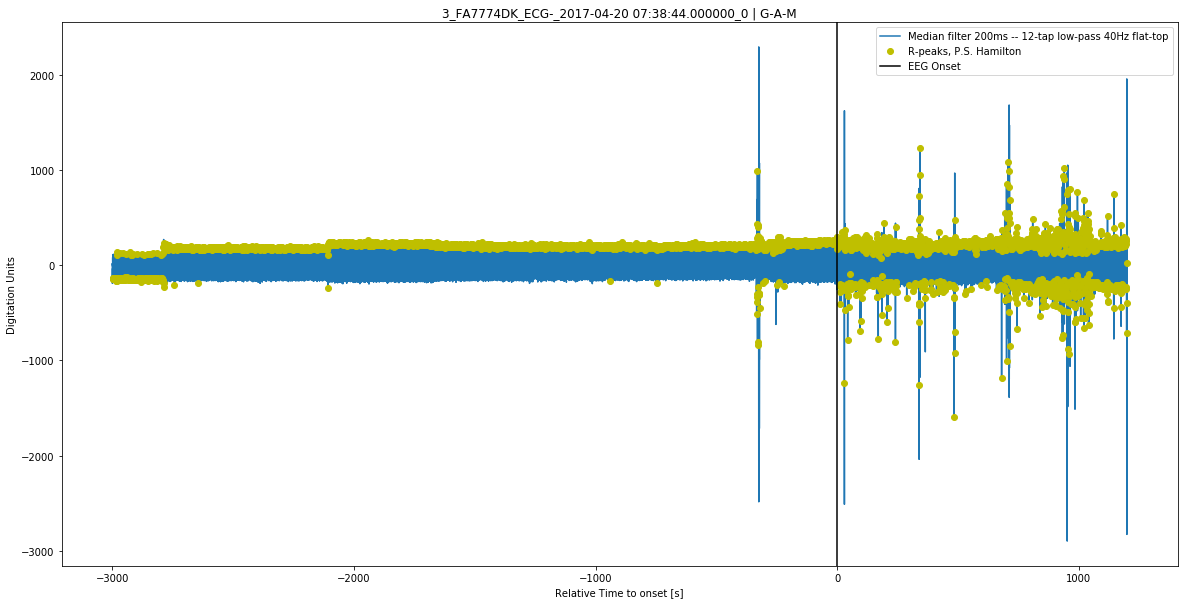

In [10]:
# Plot the signal
plt.figure(figsize=(20, 10))
plt.plot(relative_time_seconds, medianFIR_ecg.T)
plt.plot(relative_time_seconds[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'yo')
plt.axvline(x=0, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('Digitation Units')

plt.title(seizure_name + ' ' + '|' + ' ' + type_of_seizure)
plt.show() 

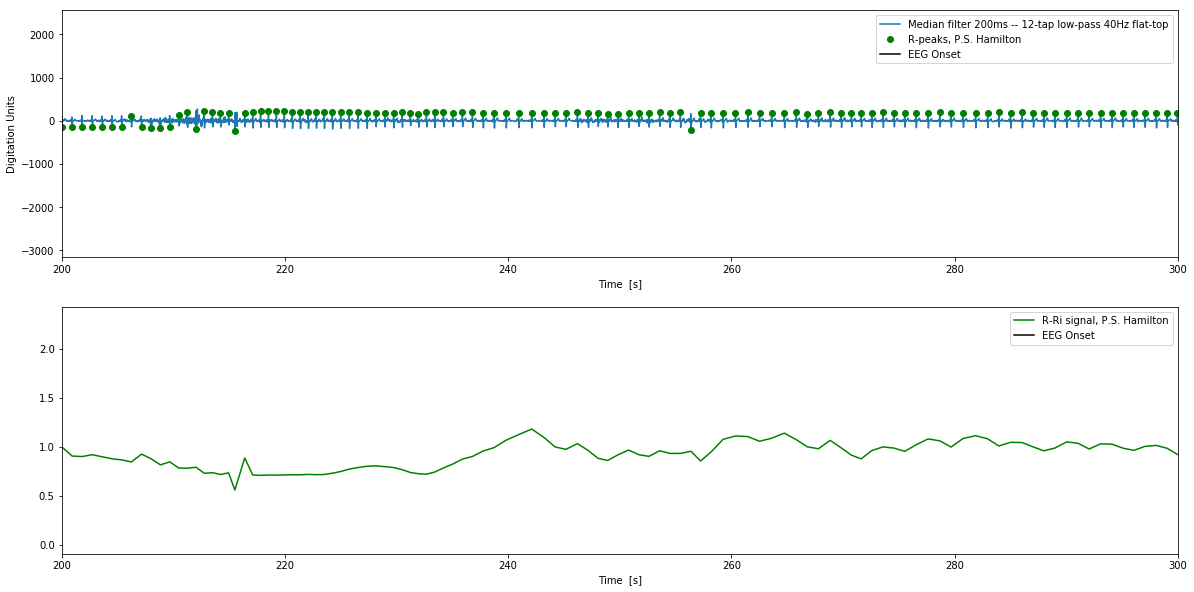

In [11]:
# Basic view RRi signal, lineplot

window = [200, 300]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'go')
plt.axvline(x=50*60, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)

plt.subplot(212)
plt.plot(time_sec_rri, rri, 'g')
plt.axvline(x=50*60, c='k')
plt.legend(['R-Ri signal, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')

plt.xlim(window)

plt.show() 

In [ ]:
# draft

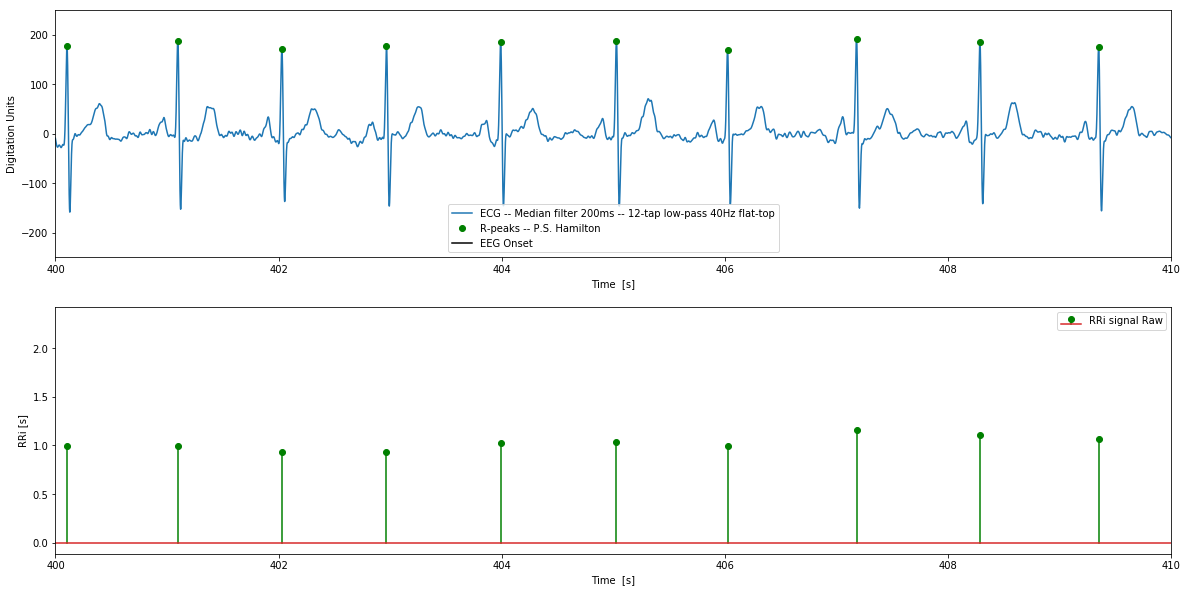

In [26]:
# Basic view RRi signal stemplot

window = [400, 410]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'go')
plt.axvline(x=50*60, c='k')
plt.legend(['ECG -- Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks -- P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)
plt.ylim([-250, 250])

plt.subplot(212)
plt.stem(time_sec_rri, rri, 'g', markerfmt='go')
plt.legend(['RRi signal Raw'])
plt.axvline(x=50*60, c='k')
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)

plt.show()

(400, 500)

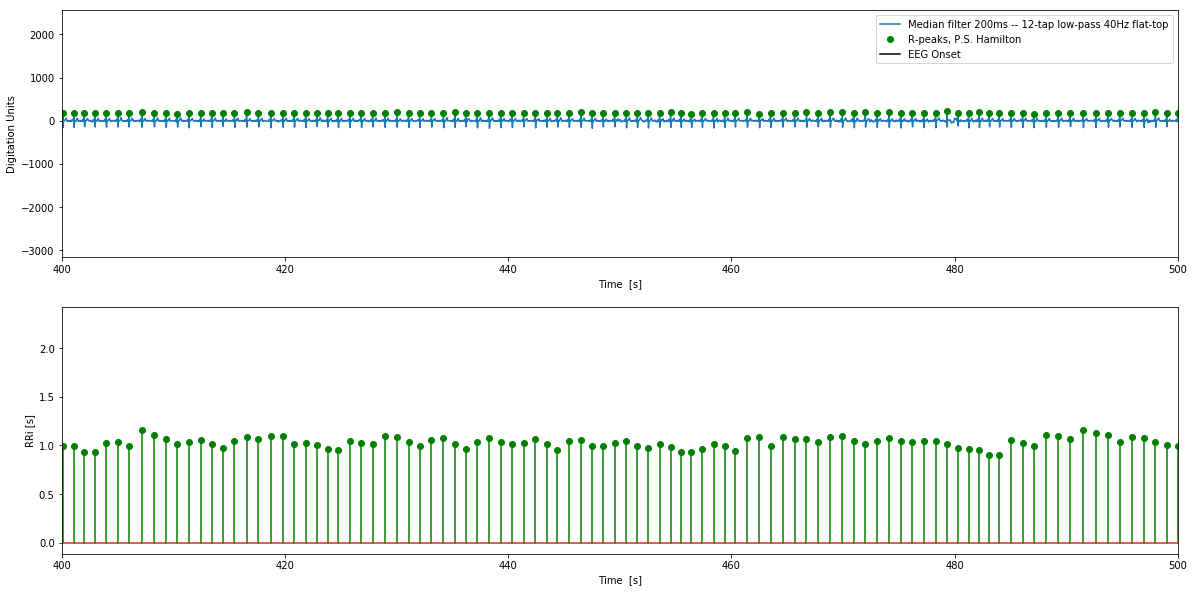

In [13]:
window = [400, 500]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(211)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'go')
plt.axvline(x=50*60, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)

plt.subplot(212)
plt.stem(time_sec_rri, rri, 'g', markerfmt='go')
plt.axvline(x=50*60, c='k')
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)




#plt.show()

In [14]:
from scipy.signal import resample
from scipy.interpolate import interp1d




# Define a window for interpolation, in seconds, right here. Make a list, it is simpler
# --->
window_interpolation = [400, 520]
#-------------------------------------------------------

# Get a window of the time samples, plus element for interpolation
time_sec_bool = np.where(np.logical_and(time_sec_rri>=window_interpolation[0],
                                        time_sec_rri<=window_interpolation[-1]))

# Get RRi signal
window_time_sec_rri = time_sec_rri[time_sec_bool]
window_rri = rri[time_sec_bool]



# Simple increase in the number of samples
# interpolation factor
L=10
n_samples=len(window_rri)

# resample - fourier method (FFT) --no assumptions on the Fs
resample_rri, resample_rri_time_sec = resample(x=window_rri,
                                               num=L*n_samples,
                                               t=window_time_sec_rri,
                                               axis=0,
                                               window=None)

# resample - cubic 
# Cubic spline method
f = interp1d(window_time_sec_rri,
             window_rri,
             kind='cubic')

new_domain = np.linspace(window_time_sec_rri[0],
                        window_time_sec_rri[-1],
                        len(window_rri) * L)
resampled_rri_window_cubic = f(new_domain)


print 'This is uneven spaced time'
print len(window_time_sec_rri)
print window_time_sec_rri[0]
print window_time_sec_rri[-1]
print ''
print '-----------------------'

print 'Interpolated time'
print len(resample_rri_time_sec)
print resample_rri_time_sec[0]
print resample_rri_time_sec[-1]
print np.diff(resample_rri_time_sec)
print ''
print '-----------------------'

print 'New Domain'
print len(new_domain)
print new_domain[0]
print new_domain[-1]
print np.diff(new_domain)


This is uneven spaced time
118
400.1030952626417
519.7041237390771

-----------------------
Interpolated time
1180
400.1030952626417
517.1778231375804
[0.09930002 0.09930002 0.09930002 ... 0.09930002 0.09930002 0.09930002]

-----------------------
New Domain
1180
400.1030952626417
519.7041237390771
[0.10144277 0.10144277 0.10144277 ... 0.10144277 0.10144277 0.10144277]


In [ ]:
window = [510, 520]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(411)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
plt.axvline(x=50*60, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)
plt.ylim([-500, 500])

plt.subplot(412)
plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')
plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal Raw'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.subplot(413)
plt.stem(resample_rri_time_sec, resample_rri, 'g', markerfmt='go')
plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal - Fourrier Interpolation - scipy.signal.resample'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.subplot(414)
plt.stem(resample_rri_time_sec, resample_rri, 'g', markerfmt='go')
plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')

plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal - Fourrier Interpolation - scipy.signal.resample', 'Raw RRi signal'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.show()

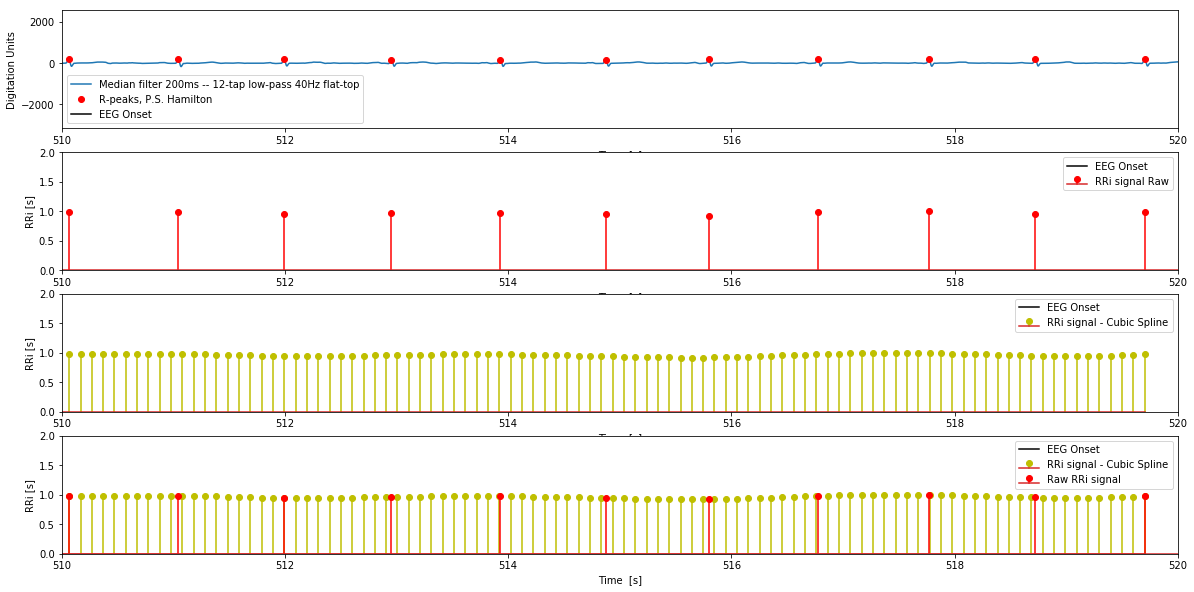

In [16]:
window = [510, 520]

# Plot the signal
plt.figure(figsize=(20, 10))

plt.subplot(411)
plt.plot(time_sec, medianFIR_ecg.T)
plt.plot(time_sec[rpeaks_hamilton], medianFIR_ecg.T[rpeaks_hamilton], 'ro')
plt.axvline(x=50*60, c='k')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'R-peaks, P.S. Hamilton', 'EEG Onset'])
plt.xlabel('Time  [s]')
plt.ylabel('Digitation Units')
plt.xlim(window)

plt.subplot(412)
plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')
plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal Raw'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.subplot(413)
plt.stem(new_domain, resampled_rri_window_cubic, 'y', markerfmt='yo')
plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal - Cubic Spline'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.subplot(414)
plt.stem(new_domain, resampled_rri_window_cubic, 'y', markerfmt='yo')
plt.stem(time_sec_rri, rri, 'r', markerfmt='ro')

plt.axvline(x=50*60, c='k')
plt.legend(['EEG Onset', 'RRi signal - Cubic Spline', 'Raw RRi signal'])
plt.xlabel('Time  [s]')
plt.ylabel('RRi [s]')
plt.xlim(window)
plt.ylim(0, 2)

plt.show()

In [17]:
# Interpolation matlab 
print window_rri

[0.99000024 0.99300024 0.93300022 0.93700022 1.02300024 1.03800025
 0.99600024 1.15500028 1.10500026 1.06500025 1.01200024 1.03700025
 1.05500025 1.01400024 0.97000023 1.04700025 1.08300026 1.06400025
 1.09900026 1.09500026 1.01200024 1.02400024 1.00900024 0.96000023
 0.95000023 1.04400025 1.02300024 1.01100024 1.09700026 1.08700026
 1.03600025 0.99800024 1.05900025 1.07500026 1.01800024 0.96700023
 1.03800025 1.07300026 1.04100025 1.01500024 1.02100024 1.06200025
 1.02000024 0.95700023 1.04600025 1.05500025 0.99700024 0.99100024
 1.03000025 1.04900025 0.99000024 0.97500023 1.02000024 0.98400023
 0.93600022 0.92800022 0.96700023 1.01600024 0.99700024 0.94400022
 1.07900026 1.08900026 0.99900024 1.09000026 1.06500025 1.07000025
 1.03700025 1.08400026 1.09300026 1.04700025 1.01100024 1.04500025
 1.08000026 1.04800025 1.03200025 1.04400025 1.04700025 1.01400024
 0.97900023 0.95900023 0.95300023 0.90600022 0.90200021 1.05200025
 1.03000025 0.99600024 1.10900026 1.09400026 1.07200026 1.1580

## 1. Trying to estimate power spectral density (PSD), using the classic Periodogram:

Building on a relatively clean window of RRi signal, it is possible to estimate the PSD based on the periodogram.

In [18]:
from scipy.signal import periodogram

# First for resampled using scipy resample:
rrwf_f, rrwf_psd_periodogram = periodogram(resample_rri,
                                           fs=L)

rrwc_f, rrwc_psd_periodogram = periodogram(resampled_rri_window_cubic,
                                           fs=L)

In [19]:
## 1. Trying to estimate power spectral density (PSD), using Yule-Walker method:

Building on a relatively clean window of RRi signal, it is possible to estimate the PSD based on the periodogram.

SyntaxError: invalid syntax (<ipython-input-19-436f1bb23553>, line 3)

In [ ]:
f_window = [0, 0.5]


plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.plot(rrwf_f, rrwf_psd_periodogram, 'g')
plt.xlim(f_window)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(222)
plt.plot(rrwc_f, rrwc_psd_periodogram, 'y')
plt.xlim(f_window)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

In [ ]:
window = [0, 70*60]

# Compare detrending with raw
plt.figure(figsize=(20, 15))

# plot the original raw ecg
plt.subplot(311)
plt.plot(time_sec, raw_ecg)
plt.axvline(x=50*60, c='k')
plt.annotate('Discontinuity', xy=(200, 50),
              xytext=(0.15, 0.80),    # fraction, fraction
              textcoords='figure fraction',
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Raw ECG', 'EEG Onset'])
plt.xlim(window)

# plot the detrended and denoised ecg
plt.subplot(312)
plt.plot(time_sec, medianFIR_ecg)
plt.annotate('Poorly removed discontinuity', xy=(200, 50),
              xytext=(0.15, 0.58),    # fraction, fraction
              textcoords='figure fraction',
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(x=50*60, c='k')
plt.xlabel('Time [s]')
plt.ylabel('Digitation Units')
plt.legend(['Median filter 200ms -- 12-tap low-pass 40Hz flat-top' , 'EEG Onset'])
plt.xlim(window)

# plot differences (direct plot)
plt.subplot(313)
plt.plot(time_sec, raw_ecg, 'r')
plt.plot(time_sec, medianFIR_ecg, 'b')
plt.axvline(x=50*60, c='k')
plt.xlabel('Time [s]')
plt.ylabel('Digitation Units')
plt.legend(['Raw ECG', 'Median filter 200ms -- 12-tap low-pass 40Hz flat-top' ,  'EEG Onset'])
plt.xlim(window)
plt.show()

In [ ]:
# time analysis
plt.figure(figsize=(20, 20))

# plot the original ecg
plt.subplot(311)
plt.plot(time_sec, raw_ecg)

# plot the original ecg
plt.subplot(312)
plt.plot(time_sec, medianFIR_ecg)
#plt.plot(time_rpeaks, medianFIR_ecg[rpeaks], 'o')

plt.subplot(313)
plt.plot(time_sec_rri, rri, 'r')

plt.show()


In [ ]:
stop

In [ ]:

# Plot the signal
plt.figure(figsize=(20, 20))
plt.plot(relative_time_sec_rri, rri)

plt.axvline(x=0, c='k')
plt.legend(['RRi signal', 'EEG Onset'])
plt.xlabel('Relative Time to onset [s]')
plt.ylabel('RRi [seconds]')
plt.title(seizure_name + ' ' + '|' + ' ' + type_of_seizure)
plt.show() 

In [ ]:
from scipy.interpolate import interp1d
from scipy.signal import upfirdn
#from scipy.signal import sinc
import matlab

time_window_flag = False

if time_window_flag==True:

    # Get window of the signal - 3min --for INTERPOLATION and resampling
    win = 3 * 60
    low = 47 * 60
    up = low + win

    # Get interpolation function --full domain of RRi and ECG signal
    f_rri = interp1d(x=time_sec_rri, y=rri)

    # Get a window of the time samples, plus elemt for interpolation
    time_sec_bool = np.where(np.logical_and(time_sec>=low, time_sec<=up))
    time_sec_rri_bool = np.where(np.logical_and(time_sec_rri>=low, time_sec_rri<=up))
    time_rpeaks_bool = np.where(np.logical_and(time_rpeaks>=low, time_rpeaks<=up))

    # Get ECG signal filtered and detrended
    time_window_sec = time_seconds[time_sec_bool]
    medianFIR_ecg_window = medianFIR_ecg_array[time_sec_bool]

    # Get R-peaks
    time_rpeaks_window = time_rpeaks[time_rpeaks_bool]
    rpeaks_window = rpeaks[time_rpeaks_bool]

    # Get RRi signal
    time_window_sec_rri = time_sec_rri[time_sec_rri_bool]
    rri_window = rri[time_sec_rri_bool]


    new_fs_list = [10, 1000]  # New factor up

    plt.figure(figsize=(20, 15))

    for i, new_fs in enumerate(new_fs_list):

        # Get new domain array --which the limits must be the window's
        num=new_fs*len(time_window_sec_rri)
        #new_domain = np.linspace(0, up, num)

        # Resampling zero-pad FIR method, details in references

        h = sinc
        resampled_rri = scipy.signal.upfirdn()


       # new_domain = np.linspace(time_window_sec_rri[0],
            #                     time_window_sec_rri[-1],
            #                     num)

        # Cubic spline method
        f = interp1d(time_window_sec_rri,
                    rri_window,
                    kind='cubic')
        resampled_rri_window_cubic = f(new_domain)


        print '------------'
        print 'This is the length of the signals'
        print 'Resampled RRi zero-pad FIR '
        print resampled_rri_window_fourrier
        print len(resampled_rri_window_fourrier)

        print '------------'
        print 'This is the length of the signals'
        print 'Resampled RRi win cubic'
        print resampled_rri_window_cubic
        print len(resampled_rri_window_cubic)

        # Estimate Power spectral Density

        # Periofograms
        rrwf_f, rrwf_psd_periodogram = periodogram(resampled_rri_window_fourrier,
                                           fs=new_fs)
        rrwc_f, rrwc_psd_periodogram = periodogram(resampled_rri_window_cubic,
                                           fs=new_fs)

        print len(rrwf_f)
        print len(rrwc_f)



        plt.subplot(2, 2, i+1)
        plt.plot(time_sec_rri[time_window_bool], rri_window,'ko-')
        plt.plot(time_resampled_rri, resampled_rri_window_fourrier ,'bo')
        #plt.plot(new_domain, resampled_rri_window_cubic, 'g')
        plt.ylabel('RRi [s]')
        plt.xlabel('Time [s]')
        plt.legend(['Raw',
                    'Resampled - zero-filling - {} - {}Hz'.format(new_fs),
                    'Cubic Spline Interpolation'])
        plt.title('3 min before EEG onset')


        plt.subplot(2, 2, (i+3))
        plt.plot(rrwf_f, rrwf_psd_periodogram ,'b')
        #plt.plot(rrwc_f, rrwc_psd_periodogram, 'g')
        plt.xlabel('frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.legend(['Resampled - zero-filling - {} - {}Hz'.format(new_fs),
                    'Cubic Spline Interpolation'])
        plt.xlim(0, 0.5)

    plt.show()

In [ ]:
import scipy.signal as signal

#Plot frequency and phase response
def mfreqz(b,a=1):
    w,h = signal.freqz(b,a)
    h_dB = 20 * log10 (abs(h))
    subplot(211)
    plot(w/max(w),h_dB)
    ylim(-150, 5)
    ylabel('Magnitude (db)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Frequency response')
    subplot(212)
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    plot(w/max(w),h_Phase)
    ylabel('Phase (radians)')
    xlabel(r'Normalized Frequency (x$\pi$rad/sample)')
    title(r'Phase response')
    subplots_adjust(hspace=0.5)

#Plot step and impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,a,impulse)
    subplot(211)
    stem(x, response)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Impulse response')
    subplot(212)
    step = cumsum(response)
    stem(x, step)
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Step response')
    subplots_adjust(hspace=0.5)

In [ ]:
# Get arrays for rri analysis

# DO NOT FORGET RAW

samples_window_flag = True

if samples_window_flag==True:
    
    # get structure of window for rri signal 
    n_samples = 180
    low = 0
    up = low + n_samples
    
    # Get RRi signal
    samples_window_time_sec_rri = time_sec_rri[low:up]
    samples_window_rri = rri[low:up]
    

    
assert len(samples_window_time_sec_rri) == 180
assert len(samples_window_rri) == 180


In [ ]:
# Resample RRi signal
from scipy.signal import resample_poly, resample, firwin, firls, upfirdn
from scipy.interpolate import interp1d
from pylab import *


# ideal interpolation (sinc)
M=4  # M is equal to 2 (number of samples non-zero used for interpolation)
L=10  # order of interpolation
alpha=0.9  # percentage of Nyquist Frequency (cutoff)

# Get filter coefficients
# simple design using windowed sinc function
h = np.sinc(alpha * (np.pi / L) * np.linspace(-M*
                                              L, M*L, 2*M*L + 1))

# Use least squares minization to obtain frequency response
Fs = L * 1  # approximate sampling rate
numtaps = 2 * M * L - 1  # order of the filter, mimicking an idealized truncated sinc FIR
bands = [alpha * 0.5, 0.5]
desired = [1, 0]
b = firls(numtaps=numtaps, bands=bands, desired=desired, nyq=0.5)

# resample - fourier method (FFT) --no assumptions on the Fs
resample_rri, resample_rri_time_sec = resample(x=samples_window_rri,
                                               num=L*n_samples,
                                               t=samples_window_time_sec_rri,
                                               axis=0,
                                               window=None)

# interp1d cubic - Cubic spline interpolation --no assumptions on the Fs
f = interp1d(samples_window_time_sec_rri,
             samples_window_rri,
             kind='cubic') # First inet


# resample - polyphasic zero_padding_method??
resamp_poly_rri = resample_poly(x=samples_window_rri, up=L, down=1, window=b)

# upfirdn - zero_padding upsampling, FIR interpolator with alpha cut-off
upfirdn_rri = upfirdn(h=b, x=samples_window_rri, up=L, down=1, axis=-1)






In [ ]:
# Assuming Fs ~1Hz


In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(611)
plt.plot(time_seconds, medianFIR_ecg.T)
plt.axvline(x=0, c='k')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)'])

plt.subplot(612)
plt.plot(time_seconds, medianFIR_ecg.T)
plt.plot(time_seconds[rpeaks], medianFIR_ecg.T[rpeaks], 'yo')
plt.axvline(x=0, c='k')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('Digitation Units')
plt.legend(['Detrended and denoised ECG signal (medianFIR)', 'rpeaks'])

plt.subplot(613)
plt.stem(samples_window_time_sec_rri, samples_window_rri, 'r',
         markerfmt='go')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('RR interval [s]')
plt.legend(['Raw RRi signal'])
plt.show()



In [ ]:
plt.subplot(614)
plt.stem(resample_rri_time_sec,
         resample_rri, 'r-')
plt.xlim([0, 10])
plt.xlabel('Time[s]')
plt.ylabel('RR interval [s]')
plt.legend(['scipy resample -- Fourrier method -- L={}'.format(L)])

plt.subplot(615)
plt.stem(resamp_poly_rri, 'g')
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.legend(['Interpolated using upfirdn'])

plt.subplot(616)
plt.stem(upfirdn_rri, 'g')
plt.legend(['Interpolated using upfirdn'])
plt.xlabel('Samples [n]')
plt.ylabel('RR interval [s]')
plt.show()

In [ ]:
# Plot the frequency response of the 'ls' interpolation filter 

plt.figure()
mfreqz(b)
plt.show()

plt.figure()
impz(b)
plt.show()



In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout

In [ ]:
init_notebook_mode(connected=True)

In [ ]:


iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])